In [1]:
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize

In [2]:
file = list(Path("../../pubchem").glob("*.csv"))

In [3]:
client = Client(n_workers=2)
client

<Client: 'tcp://127.0.0.1:44547' processes=2 threads=8, memory=31.08 GiB>

## Canonize and sanitize the smiles

In [4]:
ddf = dd.read_csv("../../Coconut/coconut_csv-03-2025_clean.csv")
df = pd.read_csv("../../Coconut/coconut_csv-03-2025_clean.csv", index_col=0)

## Clean all files

In [5]:
uncharger = rdMolStandardize.Uncharger()          # Neutralizes COO- → COOH, NH3+ → NH2, etc.
lfs = rdMolStandardize.LargestFragmentChooser()   # Removes salts, keeps largest fragment

def preprocess_smiles(smi):
    if smi is None or smi == "":
        return None
    mol = Chem.MolFromSmiles(smi, sanitize=False)
    if mol:
        try:
            # 2. Remove salts (keep largest fragment)
            mol = lfs.choose(mol)
            # 3. Neutralize charges
            mol = uncharger.uncharge(mol)
            Chem.SanitizeMol(mol) 
    
        except Exception:
            return None
        return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
    return None

In [ ]:
ddf["canonical_smiles"] = ddf["canonical_smiles"].map(preprocess_smiles, meta=("Mol", str))
ddf = ddf.dropna(subset=["canonical_smiles"])
#ddf = ddf.drop_duplicates(subset=["canonical_smiles"])
#ddf.to_parquet("../../Coconut/cleaned_coconut", write_index=False) # escribe como un null dast index, así que remove

NameError: name 'ddf' is not defined

In [7]:
for x in df.canonical_smiles:
    try:
        Chem.MolToSmiles(Chem.MolFromSmiles(x))
    except Exception as e:
        print(x)

[10:49:16] WARNING: not removing hydrogen atom without neighbors
[10:49:29] Explicit valence for atom # 1 P, 6, is greater than permitted


O=[P](=O)(O)P(=O)(=O)(O)P(=O)(=O)(O)P(=O)(=O)(O)P(=O)(=O)(O)[P](=O)(=O)O


[10:49:46] Explicit valence for atom # 20 N, 5, is greater than permitted


C/C=C\[C@H]1C[C@H]2C(=O)O[C@H](C)[C@@H](NC(=O)[C@H](CC3C[C@H]3[NH2+2]([O-])[O-])NC(=O)C3=CC=C(Cl)N3O)C(=O)NC([C@H](C)C3=CC=CC=C3)C(=O)NC(CC3C[C@H]3[NH2+2]([O-])[O-])C(=O)N[C@@H]([C@H](C)C3=CC=CC=C3)C(=O)NC([C@@H](C)CC)C(=O)N2C1


[10:49:56] WARNING: not removing hydrogen atom without neighbors
[10:50:02] Explicit valence for atom # 1 P, 6, is greater than permitted


O=[P](=O)(O)O


[10:50:06] WARNING: not removing hydrogen atom without neighbors
[10:50:06] WARNING: not removing hydrogen atom without neighbors
[10:50:10] Unusual charge on atom 37 number of radical electrons set to zero
[10:50:21] WARNING: not removing hydrogen atom without neighbors
[10:50:22] Explicit valence for atom # 0 He, 2, is greater than permitted


[HeH]C(CO)(C(N)=O)C1=CC=CC=C1


In [27]:
smile = "O=[P](=O)(O)P(=O)(=O)(O)P(=O)(=O)(O)P(=O)(=O)(O)P(=O)(=O)(O)[P](=O)(=O)O"
Chem.MolToSmiles(Chem.MolFromSmiles(smile), isomericSmiles=True) # mol to smiles failes for molecules that has problems 

[10:19:59] Explicit valence for atom # 1 P, 6, is greater than permitted


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False, bool ignoreAtomMapNumbers=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)

## Pubchem

In [15]:
from rdkit.Chem.SaltRemover import SaltRemover

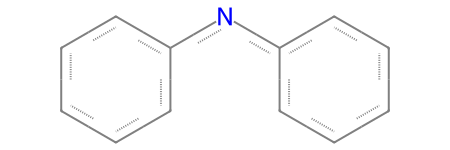

In [69]:
remover = SaltRemover()
remover.salts[14] # 15 salts are removed by default -> the largest fragment is it pertinent

In [8]:
ddf_pub = dd.read_csv(file)
df_pub = pd.read_csv(file[0], index_col=0)

In [10]:
salted = []
for i, row in ddf_pub.iterrows(): # for x in ddf_pub["SMILES"]:
    x = row["SMILES"]
    if "." in x:
        salted.append(x)
        print(i, x)

8 [H+].CC1=CC(=C(C(=C1C)S(=O)(=O)NC2=CC=CC=C2C(=O)NCCCN3C=CN=C3)C)C.[Cl-]
20 [H+].CN1CCCN(CC1)C(=O)C2=CC(=C(C=C2)Cl)S(=O)(=O)N(C)C3=CC=CC=C3.[Cl-]
31 [H+].C1COCCN1C(CNC(=O)C2=CC=C(S2)Cl)C3=CC=CS3.[Cl-]
39 [H+].C1=CC=C(C=C1)OC2=CC=CC(=C2)NC(=O)CN3C=CSC3=N.[Cl-]
69 [H+].CN(CCC1=CC=CC=N1)S(=O)(=O)C2=CC=CC=C2F.[Cl-]
76 [H+].CC1CCCN(C1)CC(COC2=CC=C(C=C2)Cl)O.[Cl-]
100 CN(C)C=O.C1CC2=CC=CC=C2N(C1)C(=O)COC(=O)C3CCN(CC3)S(=O)(=O)C4=CC=CS4
114 [H+].C1=CC=C2C(=C1)C3=CC=CC=C3N2CC(CN(CCO)CCO)O.[Cl-]
117 [H+].CN1CCCC(C1)OC(=O)CCCCC(=O)OC2CCCN(C2)C.[Cl-]
138 C1C(OC2=CC=CC=C2O1)CNCC(COCC3=CC=CS3)O.C(=O)(C(=O)O)O
140 CC(=O)C1=CC(=C(C=C1)OCC(CNCC2(CCCCC2)N3CCCCC3)O)OC.C(=O)(C(=O)O)O
170 [H+].C1CNC(=NC1)SCC2=CC(=C(C=C2)Cl)Cl.[Cl-]
179 CC1=C(SC(=C1C(=O)OC)NC(=O)CN2CCN(CC2)CC3=CC4=C(C=C3)OCO4)C.C(=O)(C(=O)O)O
211 [H+].C1CN(CCN1CCO)CC(COC2=CC3=C(C=C2)OCO3)O.[Cl-]
231 CC1=CN(C(=O)NC1=O)C2CC(C(O2)CO)N=[N+]=[N-].C1=C(NC(=S)C2=C1NC=N2)N
233 CCN(CC)C(=O)N1CCN(CC1)C.CC1C2CCC3(C(C2(CCC1O)C)C(CC4C3(CC(C4=C(CCC=C(C

In [22]:
res = ddf_pub[ddf_pub["SMILES"].str.contains("\.")].compute()

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_20524/1660728998.py:1: SyntaxWarning: invalid escape sequence '\.'
  res = ddf_pub[ddf_pub["SMILES"].str.contains("\.")].compute()


In [23]:
res.loc[432291]

ID                                                 CID_2999963
SMILES       CC1=C(SC2=C1C(=O)NC(=N2)CSC3=NC4=CC=CC=C4N3CCO...
dockscore                                                    0
Name: 432291, dtype: object

In [24]:
salted = [Chem.MolFromSmiles(x, sanitize=True) for x in salted]

[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not removing hydrogen atom without neighbors
[11:12:05] WARNING: not r

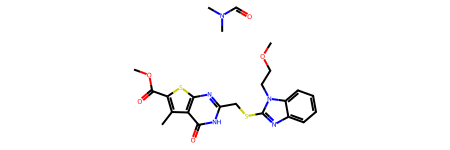

In [25]:
salted[-2]

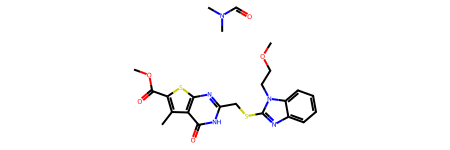

In [72]:
remover.StripMol(salted[-2])

[11:12:21] Running LargestFragmentChooser
[11:12:21] Fragment: COCCn1c(SCc2nc3sc(C(=O)OC)c(C)c3c(=O)[nH]2)nc2ccccc21
[11:12:21] New largest fragment: COCCn1c(SCc2nc3sc(C(=O)OC)c(C)c3c(=O)[nH]2)nc2ccccc21 (50)
[11:12:21] Fragment: CN(C)C=O


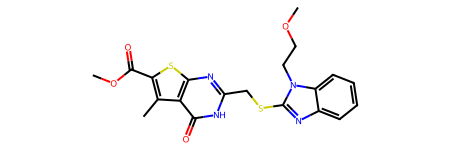

In [27]:
mol = lfs.choose(salted[-2])
mol

## Calculate HAC

In [30]:
from rdkit.Chem import Descriptors as des
from rdkit.Chem import rdMolDescriptors as rdes

In [32]:
des.HeavyAtomCount(salted[-2]), rdes.CalcNumHeavyAtoms(salted[-2]), rdes.CalcNumHeavyAtoms(mol), des.HeavyAtomCount(mol)

(35, 35, 30, 30)

In [33]:
mol.GetNumHeavyAtoms()

30